<a href="https://colab.research.google.com/github/yogasgm/data-science-machine-learning-BI/blob/main/Introduction_to_Social_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Social Network Analysis**

##**Importing required libraries**

In [ ]:
# Install necessary packages (if not already installed)
!pip install pandas networkx python-louvain --quiet

# Import essential libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community  # Louvain method for modularity detection
import numpy as np

##**Importing Dataset**

In [ ]:
# Load dataset from a public GitHub repository
url = "https://raw.githubusercontent.com/socialx-analytics/dataset-sna/refs/heads/main/data/001_redenominasi-rupiah.csv"

# Read dataset into a pandas DataFrame
df = pd.read_csv(url)

# Display the first few rows of the dataset
df.head()

,source,target
0,detikcom,ichaelza
1,detikcom,Albertbert97
2,detikfinance,detikcom
3,detikfinance,detikcom
4,detikcom,ryolandafit
...,...,...
4166,kondekturbus_,liezmecom
4167,BigAlphaID,paketchat
4168,BigAlphaID,fdnraaa
4169,BigAlphaID,Serbetwarteg__


## **Building the Network Graph**

In [ ]:
# Create a graph from the DataFrame
G = nx.from_pandas_edgelist(df, source="source", target="target")

## **Calculating Network Centrality Metrics**

In [ ]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=500)

In [ ]:
# Store centrality measures in a DataFrame
centrality_df = pd.DataFrame({
    "Node": degree_centrality.keys(),
    "Degree Centrality": degree_centrality.values(),
    "Betweenness Centrality": betweenness_centrality.values(),
    "Closeness Centrality": closeness_centrality.values(),
    "Eigenvector Centrality": eigenvector_centrality.values()
})

# Display centrality scores
centrality_df

,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
0,detikcom,0.196338,0.495644,0.369329,9.188173e-03
1,ichaelza,0.000339,0.000000,0.266534,2.466670e-04
2,Albertbert97,0.000339,0.000000,0.266534,2.466670e-04
3,detikfinance,0.064768,0.160052,0.338475,5.788202e-03
4,ryolandafit,0.000678,0.002379,0.270455,2.492737e-04
...,...,...,...,...,...
2945,RamudengTenan,0.001017,0.000864,0.274326,4.168852e-04
2946,Junwaelah,0.000339,0.000000,0.000610,5.326953e-212
2947,uccy_sty,0.000339,0.000000,0.266534,2.466670e-04
2948,Paulabolobolo,0.000339,0.000000,0.000452,8.537222e-222


## **Community Detection Using Louvain Method**

In [ ]:
# Apply Louvain method to detect communities
partition = community.best_partition(G)

# Calculate modularity score to measure the strength of the division
modularity_score = community.modularity(partition, G)

# Print modularity score
print("\n=== Modularity Score ===")
print(f"Modularity: {modularity_score:.4f}")


=== Modularity ===
Modularity: 0.7036


## **Network Visualization**

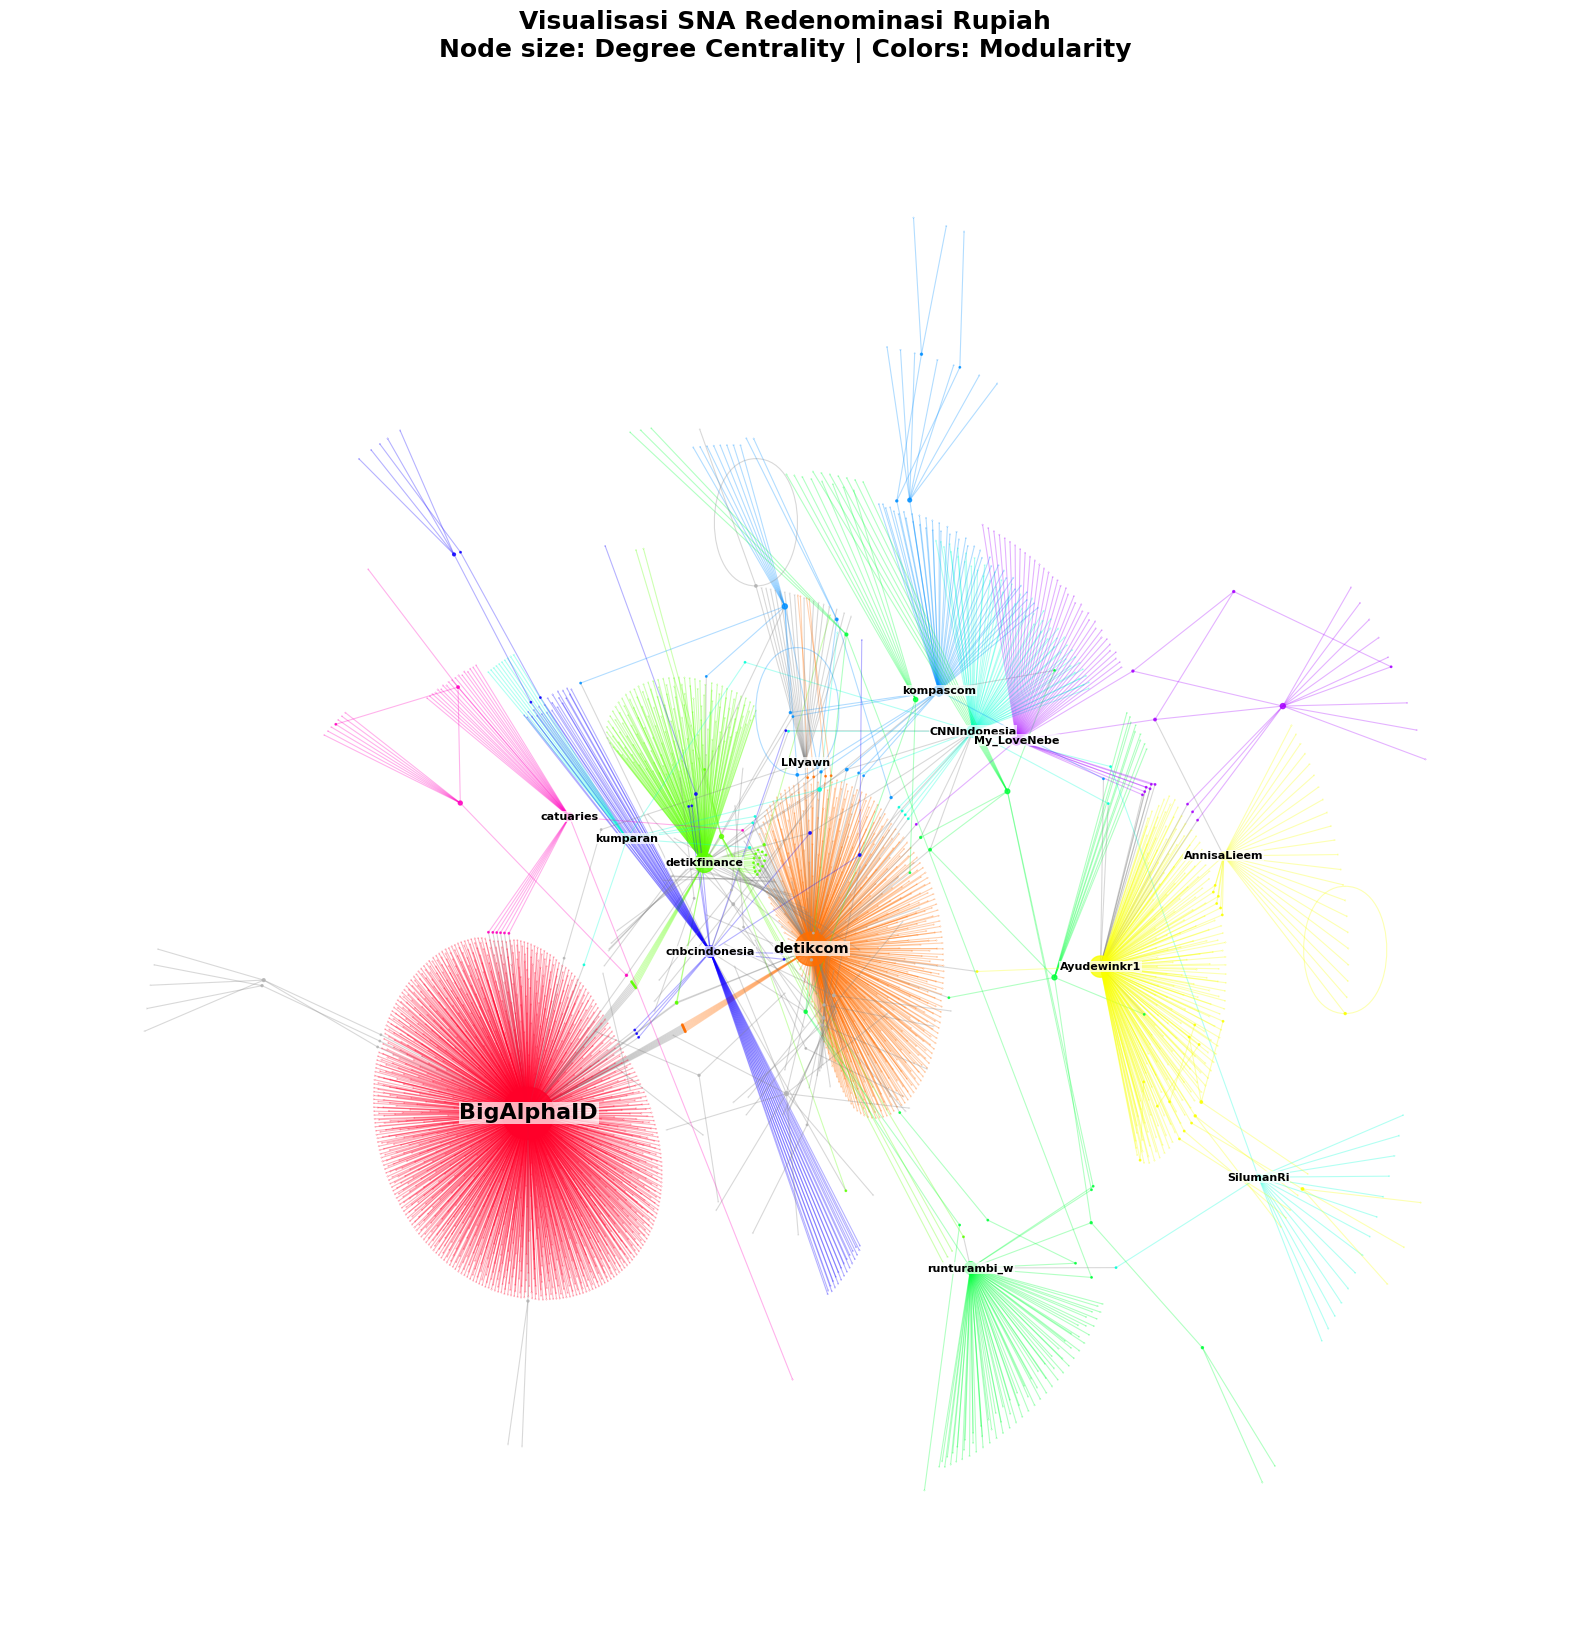

In [ ]:
# Set figure size and background color
plt.figure(figsize=(20, 20), facecolor='white')
ax = plt.gca()  # Get Current Axis

# Select graph layout
pos = nx.kamada_kawai_layout(G)

# 1. COMMUNITY ANALYSIS
# Count the number of nodes in each community
community_sizes = {}
for node, comm in partition.items():
    community_sizes[comm] = community_sizes.get(comm, 0) + 1

# Taking the 10 largest communities based on the number of nodes
top_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:10]
top_community_ids = [comm[0] for comm in top_communities]

# 2. SETTING THE NODE SIZE
# Set the node size based on degree centrality
# min_size=-1 for the smallest node, max_size=3000 for the largest node
min_size = -1
max_size = 3000
node_sizes = [min_size + (v * (max_size - min_size)) for v in degree_centrality.values()]

#3. COLOR SETTINGS
# Create a color palette for the top 10 communities using gist_rainbow
colors = plt.cm.gist_rainbow(np.linspace(0, 1, 10))

# Assign a color to each node
node_colors = []
for node in G.nodes():
    if partition[node] in top_community_ids:
        # Nodes in the top 10 communities are colored according to their community
        color_idx = top_community_ids.index(partition[node])
        node_colors.append(colors[color_idx])
    else:
        # Nodes outside the top 10 communities are colored transparent gray
        node_colors.append((0.7, 0.7, 0.7, 0.5))

# Assign a color to each edge
edge_colors = []
for edge in G.edges():
    source_comm = partition[edge[0]]
    target_comm = partition[edge[1]]
    if source_comm == target_comm and source_comm in top_community_ids:
        # Edges connecting nodes in the same community (top 10) are assigned a community color
        color_idx = top_community_ids.index(source_comm)
        edge_colors.append(colors[color_idx])
    else:
        # Other Edge is given a very transparent gray color
        edge_colors.append((0.5, 0.5, 0.5, 0.1))

# 4. DRAWING NETWORK
# Draw edges with transparency 0.3
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=edge_colors, width=0.8)

# Draw nodes with transparency 0.8
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)

# 5. LABEL SETTINGS
# Only display labels for nodes with degree centrality > 0.005
labels = {}
for node in G.nodes():
    if degree_centrality[node] > 0.005:
        labels[node] = node

# Set the label font size proportional to the node size
max_size = max(node_sizes)
font_sizes = {node: min(max(size/max_size * 25, 8), 16) for node, size in zip(G.nodes(), node_sizes)}
font_sizes = {node: font_sizes[node] if node in labels else 0 for node in G.nodes()}

# Add white background to labels for readability
for node, label in labels.items():
    offset = np.sqrt(node_sizes[list(G.nodes()).index(node)]) / 100
    plt.annotate(label,
                xy=pos[node],
                xytext=(offset, offset),
                textcoords='offset points',
                fontsize=font_sizes[node],
                fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5),
                horizontalalignment='center',
                verticalalignment='center')

# 6. VISUALIZATION FINALIZATION
# Add title
plt.title("Visualisasi SNA Redenominasi Rupiah\nNode size: Degree Centrality | Colors: Modularity",
          fontsize=18, pad=20, fontweight='bold')

# Eliminate axis
plt.axis('off')

# Keeping the background white
plt.gcf().patch.set_facecolor('white')

# Display visualization
plt.show()